# Can Topological Divergences Help Predict the Largest Lyapunov Exponent?

## Overview

This notebook generates dynamic system trajectory data then analyses multiple features for supervised learning of the largest Lyapunov exponent (classification and regression). Classical numeric methods, TDA-based methods, Horizontal Visibility methods, and our newly introduced topological divergences are compared.

- classic neighbour-tracing estimators from Rosenstein, Eckmann, and Kantz
- ordinal partition network embedded persistence measures from Myers
- $k$-nearest neighbour graph embedded persistence measures from Myers
- Betti vector norms on embedded trajectories from Güzel
- topological divergences (the main contribution)

Topological divergences are scalar or vector valued measures of the difference between the sublevel and superlevel filtrations over a scalar function.

In [1]:
# collect imports for cells below

import numpy as np
import numpy.ma as ma
import pandas as pd
from functools import partial
from TimeSeriesMergeTreeSimple import TimeSeriesMergeTree as TSMT
from ipyparallel import require
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tree_offset_divergence import get_offset_divergences
from tree_offset_divergence import div_names as merge_tree_divergence_names
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
from trajectories import generate_trajectories



In [2]:
# Provide clients to an ipyparallel cluster for faster parallel processing

import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [3]:
# Preprocessing function to remove scale bias in supervised learning

def scale(ts):
    """Make range of ts fall between 0 and 1"""
    scaler = MinMaxScaler()
    return scaler.fit_transform(ts.reshape(-1, 1)).flatten()


## Chaotic system data

In [175]:
# Specify the trajectory generation criteria

SEED = 42  # consistent random number generation
SAMPLES = 1000  # number of trajectories
LENGTH = 2000  # number of points per trajectory

In [176]:
# Generate the actual system data to analyse

system_training_data = generate_trajectories(RANDOM_SEED=SEED, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=SAMPLES)

Experiment config -- SEED:42, LENGTH:2000, SAMPLES:1000


In [177]:
# Remove relative scale (amplitude) as a feature that could be used in supevised learning

for system in system_training_data:
    trajectories = system_training_data[system]["trajectories"]
    trajectories = list(map(scale, trajectories))
    system_training_data[system]["trajectories"] = trajectories


## Supervised learning

In [178]:
# Define machine learning models to train on the Lyapunov estimates

def score_features_train(feature_names, features, y_true, cv=5, n_repeats=5, ML_SEED=123):
    """Score various supervised ML models on supplied features give a ground truth.
    
    For classification, assumes ground truth y_true>0 is the positive class.
    """

    # assume vectorial features; if scalar, add an extra dimension
    features = np.array(features)
    if features.ndim == 2:
        features = features[..., np.newaxis]
    n_samples, n_features, feature_vector_length = features.shape

    CLASSIFIER_CV = RepeatedStratifiedKFold(n_splits=cv, random_state=ML_SEED, n_repeats=n_repeats)
    REGRESSOR_CV = RepeatedKFold(n_splits=cv, random_state=ML_SEED*2, n_repeats=n_repeats)

    y = y_true
    pos_mask = y>0


    for i in range(n_features):
        feature_name = feature_names[i]
        X = features[:, i, :].reshape(n_samples, -1)

        SVC_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=ML_SEED))])
        SVC_clf = GridSearchCV(SVC_pipe, {'svc__C':[0.01, 0.1, 1, 10, 100]}, scoring="roc_auc", n_jobs=-2, refit=True, cv=CLASSIFIER_CV)
        SVC_clf.fit(X, pos_mask)
        SVC_scores = cross_val_score(SVC_clf.best_estimator_, X, pos_mask, scoring="roc_auc", cv=CLASSIFIER_CV, n_jobs=-2)

        KNR_all_pipe = Pipeline([('scaler', StandardScaler()), ('knr', KNeighborsRegressor())])
        KNR_all_clf = GridSearchCV(KNR_all_pipe, {'knr__n_neighbors': [10, 15, 20, 25, 30]}, n_jobs=-2, scoring="r2", cv=REGRESSOR_CV, refit=True)
        KNR_all_clf.fit(X, y)
        KNR_all_scores = cross_val_score(KNR_all_clf.best_estimator_, X, y, scoring="r2", cv=REGRESSOR_CV, n_jobs=-2)

        KNR_chaos_pipe = Pipeline([('scaler', StandardScaler()), ('knr', KNeighborsRegressor())])
        KNR_chaos_clf = GridSearchCV(KNR_chaos_pipe, {'knr__n_neighbors': [10, 15, 20, 25, 30]}, n_jobs=-2, scoring="r2", cv=REGRESSOR_CV, refit=True)
        KNR_chaos_clf.fit(X[pos_mask], y[pos_mask])
        KNR_chaos_scores = cross_val_score(KNR_chaos_clf.best_estimator_, X[pos_mask], y[pos_mask], scoring="r2", cv=REGRESSOR_CV, n_jobs=-2)

        SVR_all_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
        SVR_all_clf = GridSearchCV(SVR_all_pipe, {'svr__C':[0.01, 0.1, 1, 10, 100]}, scoring="r2", n_jobs=-2, refit=True, cv=REGRESSOR_CV)
        SVR_all_clf.fit(X, y)
        SVR_all_scores = cross_val_score(SVR_all_clf.best_estimator_, X, y, scoring="r2", cv=REGRESSOR_CV, n_jobs=-2)

        SVR_chaos_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
        SVR_chaos_clf = GridSearchCV(SVR_chaos_pipe, {'svr__C':[0.01, 0.1, 1, 10, 100]}, scoring="r2", n_jobs=-2, refit=True, cv=REGRESSOR_CV)
        SVR_chaos_clf.fit(X[pos_mask], y[pos_mask])
        SVR_chaos_scores = cross_val_score(SVR_chaos_clf.best_estimator_, X[pos_mask], y[pos_mask], scoring="r2", cv=REGRESSOR_CV, n_jobs=-2)

        # add attribute to check if a model is for all data or just chaotic data
        setattr(KNR_chaos_clf, "chaos", True)
        setattr(SVR_chaos_clf, "chaos", True)

        yield {
            feature_name: {
                "scores": {
                    "SVC": SVC_scores,
                    "KNR_all": KNR_all_scores,
                    "KNR_chaos": KNR_chaos_scores,
                    "SVR_all": SVR_all_scores,
                    "SVR_chaos": SVR_chaos_scores,

                },
                "models": {
                    "SVC": SVC_clf,
                    "KNR_all": KNR_all_clf,
                    "KNR_chaos": KNR_chaos_clf,
                    "SVR_all": SVR_all_clf,
                    "SVR_chaos": SVR_chaos_clf,
                }
            }
        }


In [179]:
# Apply trained machine models to features from new unseen data

def score_features_test(feature_names, features, y_true, trained_models):
    """Predict using features as input to trained models and score against ground truth.
    
    For classification, assumes ground truth y_true>0 is the positive class.
    """

    # assume vectorial features; if scalar, add an extra dimension
    features = np.array(features)
    if features.ndim == 2:
        features = features[..., np.newaxis]
    n_samples, n_features, feature_vector_length = features.shape
    
    is_classifier = lambda clf: hasattr(clf, "classes_")

    pos_mask = y_true>0

    for i in range(n_features):
        feature_name = feature_names[i]
        X = features[:, i, :].reshape(n_samples, -1)

        yield {
            feature_name: {
                "predictions": {
                    model_name: trained_model.predict(
                        X[pos_mask] if getattr(trained_model, "chaos", False) else X
                    ) for model_name, trained_model in trained_models[feature_name].items()
                },
                "scores": {
                    model_name: trained_model.score(
                        (X[pos_mask] if getattr(trained_model, "chaos", False) else X),
                        (y_true[pos_mask] if getattr(trained_model, "chaos", False) else (pos_mask if is_classifier(trained_model) else y_true))
                    )
                    for model_name, trained_model in trained_models[feature_name].items()
                }
            }
        }

        

## Topological Divergences

First we look at topological merge tree offset path length distributions.

In [182]:
# Set up parameters for the cells below

SYSTEM = "logistic"  # current system being investigated
REP_FUNC = partial(TSMT, discrete=True)  # current mode of representing trajectories
OFFSETS = range(1,125,12)  # offsets for merge tree divergences

In [183]:
# Apply the representation constructor and get a representation of each trajectory

merge_tree_representations_train = list(map(REP_FUNC, system_training_data[SYSTEM]["trajectories"]))

In [184]:
# Parallel function to compute divergences for a single merge tree representation

@require(partial=partial, get_offset_divergences=get_offset_divergences, OFFSETS=OFFSETS)
def merge_tree_divergence_features(rep):
    import numpy as np
    div_values = list(map(partial(get_offset_divergences, tsmt=rep), OFFSETS))
    return np.array(div_values).T


In [185]:
# Compute the divergences for each merge tree representation in parallel

merge_tree_divergence_features_train = lbv.map_sync(merge_tree_divergence_features, merge_tree_representations_train)
# merge_tree_divergence_features_train = list(map(merge_tree_divergence_features, merge_tree_representations_train))

# Convert list to array of shape (n_trajectories, n_divergences, vector_length)

merge_tree_divergence_features_train = np.array(merge_tree_divergence_features_train)

### Supvervised learning evaluation of divergences as features

In [186]:
# Define the ground truth for model training

y_train = system_training_data[SYSTEM]["lces"]

In [187]:
# Compute the supervised learning model scores for the topological divergence features on training data

merge_tree_divergence_train_results = {SYSTEM: {}}
for result in score_features_train(merge_tree_divergence_names, merge_tree_divergence_features_train, y_train):
    merge_tree_divergence_train_results[SYSTEM] |= result


### Training results summary

In [188]:
# Extract the scores and the best-performing models from the results dictionary

merge_tree_divergence_train_scores = {k:v["scores"] for k,v in merge_tree_divergence_train_results[SYSTEM].items()}
merge_tree_divergence_train_best_models = {k:v["models"] for k,v in merge_tree_divergence_train_results[SYSTEM].items()}

In [189]:
# Display the mean scores for the supervised learning using each divergence

merge_tree_divergence_train_scores_df = pd.DataFrame(merge_tree_divergence_train_scores)
merge_tree_divergence_train_scores_df_means = merge_tree_divergence_train_scores_df.applymap(np.mean).T
merge_tree_divergence_train_scores_df_means

,SVC,KNR_all,KNR_chaos,SVR_all,SVR_chaos
path_length_l1,0.989439,0.754946,0.671486,0.772573,0.649683
path_length_l2,0.983161,0.713561,0.520419,0.726129,0.542998
path_length_linf,0.816545,0.117007,0.389336,0.188432,0.381889
path_length_hist_w,0.993652,0.806505,0.839515,0.832401,0.810514
path_length_hist_l1,0.974945,0.513085,0.503017,0.546730,0.715319
path_length_hist_l2,0.971503,0.506010,0.423808,0.532558,0.726382
path_length_hist_linf,0.968361,0.462525,0.405974,0.462712,0.685951
cophenetic_length_l1,0.981958,0.682024,0.209766,0.648189,0.231435
cophenetic_length_l2,0.968573,0.584855,0.090776,0.572581,0.126062
cophenetic_length_linf,0.941043,0.376602,-0.020695,0.412279,0.002533


In [190]:
best_svr_all_feature = merge_tree_divergence_train_scores_df_means["SVR_all"].idxmax()
best_svc_feature = merge_tree_divergence_train_scores_df_means["SVC"].idxmax()
best_svc_feature, best_svr_all_feature

('path_weight_hist_l2', 'cophenetic_weight_hist_l2')

### Predictions

To illustrate the predictive power of the resulting feature(s) we use computed divergences for training and predict $\lambda_{\max}$ for new unseen trajectories.

#### Test Data

In [191]:
# Set up test data for predictions, different to the training and validation data used above

system_test_data = generate_trajectories(RANDOM_SEED=SEED*2, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=501)
test_trajectories = system_test_data[SYSTEM]["trajectories"]
test_param_name = system_test_data[SYSTEM]["param_name"]
test_params = system_test_data[SYSTEM]["sys_params"]
y_test = system_test_data[SYSTEM]["lces"]

Experiment config -- SEED:84, LENGTH:2000, SAMPLES:501


In [192]:
# Remove relative scale (amplitude) as a feature that could be used in supevised learning

for system in system_test_data:
    trajectories = system_test_data[system]["trajectories"]
    trajectories = list(map(scale, trajectories))
    system_test_data[system]["trajectories"] = trajectories


#### Test Features

In [193]:
# Compute divergences for each merge tree representation of test data in parallel

merge_tree_representations_test = list(map(REP_FUNC, test_trajectories))
merge_tree_divergence_features_test = lbv.map_sync(merge_tree_divergence_features, merge_tree_representations_test)
# merge_tree_divergence_features_test = list(map(merge_tree_divergence_features, merge_tree_representations_test))

# array of shape (n_trajectories, n_divergences, vector_length)
merge_tree_divergence_features_test = np.array(merge_tree_divergence_features_test)

In [194]:
# Sanity check the ML scores for the topological divergence features of the test set separately

merge_tree_divergence_test_results = {SYSTEM: {}}
for result in score_features_test(merge_tree_divergence_names, merge_tree_divergence_features_test, y_test, merge_tree_divergence_train_best_models):
    merge_tree_divergence_test_results[SYSTEM] |= result


### Test results summary

In [195]:
merge_tree_divergence_test_scores = {k:v["scores"] for k,v in merge_tree_divergence_test_results[SYSTEM].items()}
merge_tree_divergence_test_predictions = {k:v["predictions"] for k,v in merge_tree_divergence_test_results[SYSTEM].items()}

In [196]:
# Display the mean scores for the supervised learning using each divergence

merge_tree_divergence_test_scores_df = pd.DataFrame(merge_tree_divergence_test_scores)
merge_tree_divergence_test_scores_df_means = merge_tree_divergence_test_scores_df.applymap(np.mean).T
merge_tree_divergence_test_scores_df_means

,SVC,KNR_all,KNR_chaos,SVR_all,SVR_chaos
path_length_l1,0.998581,0.790275,0.767980,0.816920,0.739262
path_length_l2,0.995455,0.779546,0.626375,0.778034,0.638113
path_length_linf,0.800168,0.027755,0.348188,0.159478,0.364911
path_length_hist_w,0.996104,0.822631,0.857237,0.839693,0.799723
path_length_hist_l1,0.970322,0.511171,0.492822,0.522461,0.723325
path_length_hist_l2,0.968494,0.515972,0.461399,0.562907,0.747926
path_length_hist_linf,0.968903,0.511907,0.457420,0.519248,0.714442
cophenetic_length_l1,0.989153,0.668402,0.184511,0.610237,0.219765
cophenetic_length_l2,0.968735,0.564493,0.159469,0.561607,0.184064
cophenetic_length_linf,0.935257,0.335585,-0.032245,0.345721,-0.015883


### Test results visualisation

In [221]:
prediction_feature_name = "cophenetic_weight_hist_l1"
prediction_model_name = "SVR_all"
y_pred = merge_tree_divergence_test_predictions[prediction_feature_name][prediction_model_name]

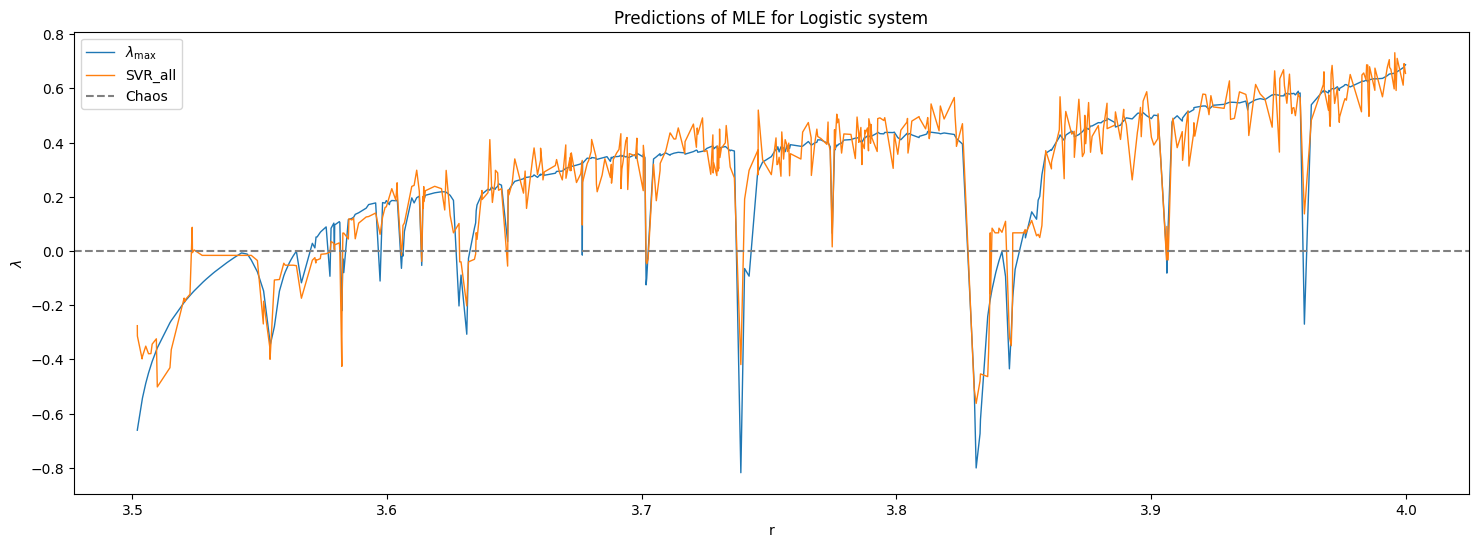

In [223]:
# plot the ground truth and regression predictions
plt.figure(figsize=(18,6))
plt.plot(test_params, y_test, lw=1, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred, lw=1, label=prediction_model_name)
plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(f"Predictions of MLE for {SYSTEM.capitalize()} system")
plt.show()


In [219]:
prediction_feature_name = "cophenetic_weight_l1"
prediction_model_name = "SVC"
y_pred = merge_tree_divergence_test_predictions[prediction_feature_name][prediction_model_name]

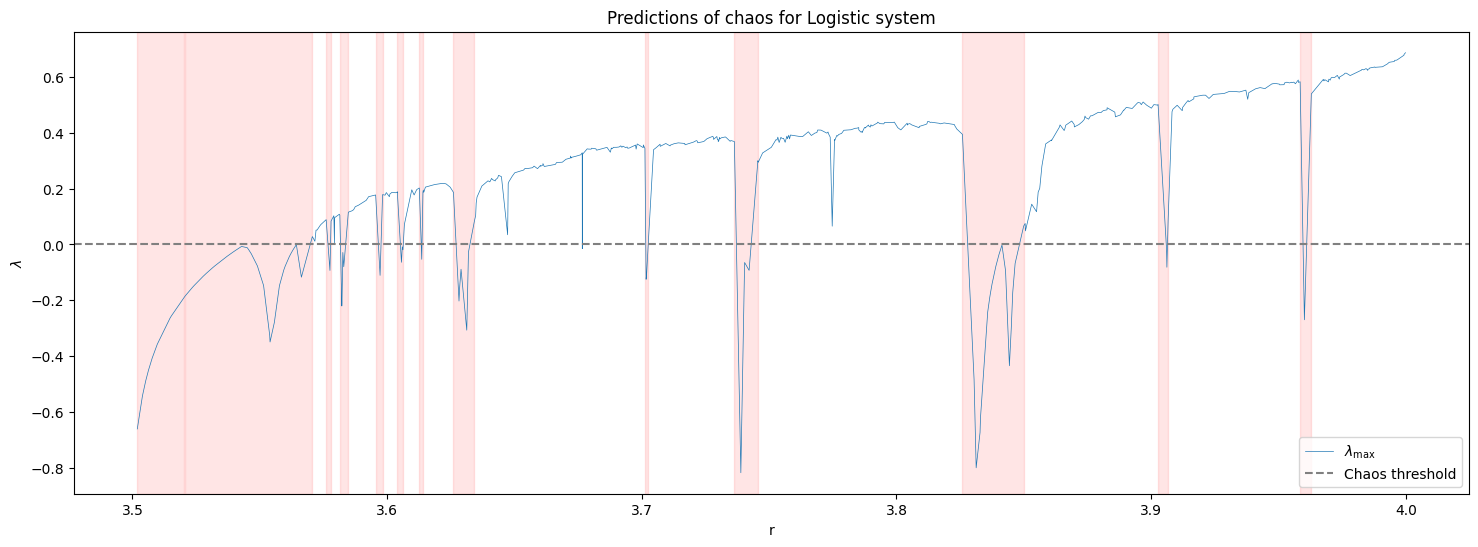

In [220]:
# plot the ground truth
plt.figure(figsize=(18,6))
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")

# plot the classification predictions as vspans over the graph
# predicted_non_chaos = y_pred < 0.025
predicted_non_chaos = y_pred == False
x = test_params

# mark sections of the x-axis where predicted_non_chaos is True
start = x[0] if predicted_non_chaos[0] else None
for i in range(1, len(predicted_non_chaos)):
    if not predicted_non_chaos[i-1] and predicted_non_chaos[i]:
        start = x[i-1]
    elif predicted_non_chaos[i-1] and not predicted_non_chaos[i]:
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)
            start = None
    elif i == len(predicted_non_chaos)-1 and not predicted_non_chaos[i]:  # case for the end of the array
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos threshold')
plt.legend()
plt.title(f"Predictions of chaos for {SYSTEM.capitalize()} system")
plt.show()


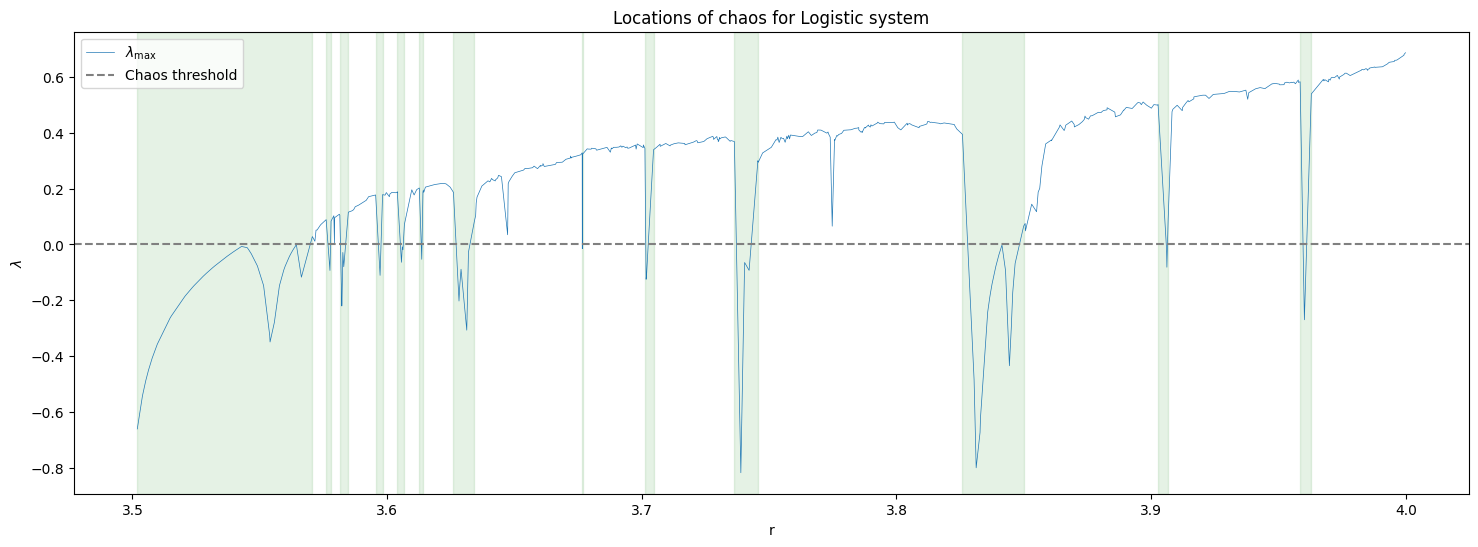

In [224]:
# plot the ground truth
plt.figure(figsize=(18,6))
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")

# plot the classification predictions as vspans over the graph
# predicted_non_chaos = y_pred < 0.025
predicted_non_chaos = y_test <= 0
x = test_params

# mark sections of the x-axis where predicted_non_chaos is True
start = x[0] if predicted_non_chaos[0] else None
for i in range(1, len(predicted_non_chaos)):
    if not predicted_non_chaos[i-1] and predicted_non_chaos[i]:
        start = x[i-1]
    elif predicted_non_chaos[i-1] and not predicted_non_chaos[i]:
        if start is not None:
            plt.axvspan(start, x[i], color='green', alpha=0.1)
            start = None
    elif i == len(predicted_non_chaos)-1 and not predicted_non_chaos[i]:  # case for the end of the array
        if start is not None:
            plt.axvspan(start, x[i], color='green', alpha=0.1)

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos threshold')
plt.legend()
plt.title(f"Locations of chaos for {SYSTEM.capitalize()} system")
plt.show()


### Hyperparameters of the divergence-based estimates

The following can be considered for variation in a wider-range study.

- Offset range and step size - equivalently offset range and number of offsets
- Dimension of the histogram vectors being compared
- Discrete vs piecewise linear merge trees


## Classic Estimators

In [ ]:
from classic_estimators import get_classic_estimates, classic_names

In [ ]:
classic_estimates_list = list(lbv.map_sync(get_classic_estimates, system_training_data[SYSTEM]["trajectories"]))

In [ ]:
classic_estimates = np.array(classic_estimates_list)

In [ ]:
def make_inf_column_finite(arr):
    """Convert -inf and +inf to min finite value in each column."""

    arr_isinf = np.isinf(arr)
    col_mins = np.min(ma.masked_array(arr, mask=arr_isinf, fill_value=0), axis=0)

    for row_idx in range(arr.shape[0]):
        for col_idx in range(arr.shape[1]):
            if np.isinf(arr[row_idx, col_idx]):
                arr[row_idx, col_idx] = col_mins[col_idx]
                arr[np.isnan(arr)] = -1e-12

    return arr

In [ ]:
classic_estimates_finite = make_inf_column_finite(classic_estimates)

In [ ]:
classic_estimates_finite

array([[-2.62466485e-01, -2.41580665e-01, -2.51436059e+01],
       [-2.62466485e-01, -2.41580665e-01, -2.51436059e+01],
       [-2.62466485e-01, -2.41580665e-01, -2.51436059e+01],
       ...,
       [ 9.76280795e-03,  4.55756396e-01,  2.78699939e-01],
       [ 1.04262404e-03,  4.22874779e-01,  1.61333506e-01],
       [-2.60043521e-03,  4.08968002e-01,  1.77417111e-01]])

In [ ]:
classic_results = {SYSTEM: {}}
for result in score_features_train(classic_names, classic_estimates[..., np.newaxis], system_training_data[SYSTEM]):
    print(result)
    classic_results[SYSTEM] |= result

{'Rosenstein': {'SVC': array([0.97149123, 0.98135965, 1.        , 0.94901316, 1.        ,
       0.96107456, 0.9566886 , 0.98355263, 0.99945175, 1.        ,
       0.9375    , 0.98629386, 0.99945175, 0.98135965, 0.99830604,
       0.95833333, 1.        , 0.97149123, 0.98190789, 0.98531903,
       0.97807018, 0.97861842, 0.99890351, 0.98190789, 0.95652174,
       0.98190789, 0.95997807, 0.97039474, 0.99890351, 0.98362507,
       1.        , 0.95888158, 0.96765351, 0.98026316, 1.        ,
       0.97039474, 0.95778509, 0.98410088, 0.98574561, 1.        ,
       0.98300439, 0.99232456, 0.97752193, 0.98464912, 0.95652174,
       1.        , 0.98574561, 0.97532895, 0.95339912, 0.9785432 ]), 'KNR_all': array([0.79698685, 0.61846223, 0.68079772, 0.69577517, 0.64700781,
       0.64782013, 0.74131532, 0.72940426, 0.81721319, 0.57329006,
       0.65452947, 0.78539534, 0.69851874, 0.71827225, 0.67767247,
       0.69203818, 0.77168574, 0.67905355, 0.71420727, 0.6476815 ,
       0.53993811, 0.77178

In [ ]:
# Display the mean scores for the supervised learning using each divergence

classic_scores_df = pd.DataFrame(classic_results[SYSTEM])
classic_scores_df_means = classic_scores_df.applymap(np.mean).T
classic_scores_df_means

,SVC,KNR_all,KNR_chaos,SVR_all,SVR_chaos
Rosenstein,0.979666,0.701682,0.026834,0.637751,0.055674
Eckmann,0.941171,0.723599,0.329909,0.718826,0.340700
Kantz,0.992202,0.680461,0.709726,0.830417,0.704635


In [ ]:
# Also compute scores for "direct" estimation using the classic features - since the values are direct estimates

rosenstesin_class_score = roc_auc_score(system_training_data[SYSTEM]["lces"]>0, classic_estimates[:,0]>0)
eckmann_class_score = roc_auc_score(system_training_data[SYSTEM]["lces"]>0, classic_estimates[:,1]>0)
kantz_class_score = roc_auc_score(system_training_data[SYSTEM]["lces"]>0, classic_estimates[:,2]>0)

In [ ]:
rosenstesin_class_score, eckmann_class_score, kantz_class_score

(0.8900174242925516, 0.6722689075630253, 0.7650918635170604)

In [ ]:
# Also compute scores for "direct" estimation using the classic features - since the values are direct estimates

rosenstesin_regress_score = r2_score(system_training_data[SYSTEM]["lces"], classic_estimates[:,0])
eckmann_regress_score = r2_score(system_training_data[SYSTEM]["lces"], classic_estimates[:,1])
kantz_regress_score = r2_score(system_training_data[SYSTEM]["lces"], classic_estimates[:,2])

In [ ]:
rosenstesin_regress_score, eckmann_regress_score, kantz_regress_score

(-0.2960974041183295, -3.616091698385886, -1422.8203937269932)

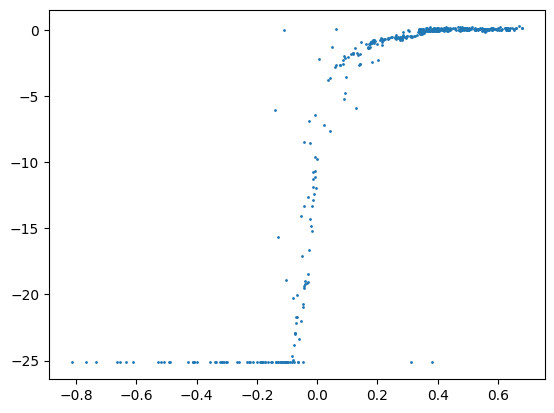

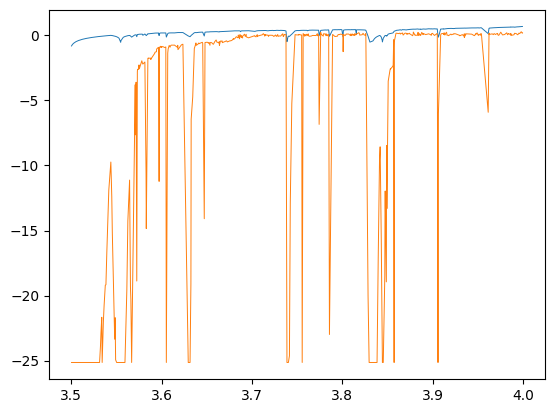

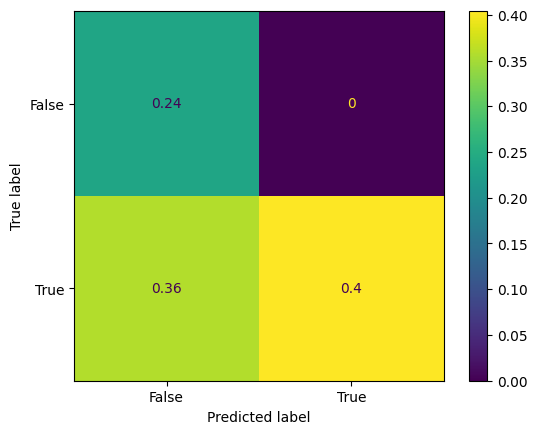

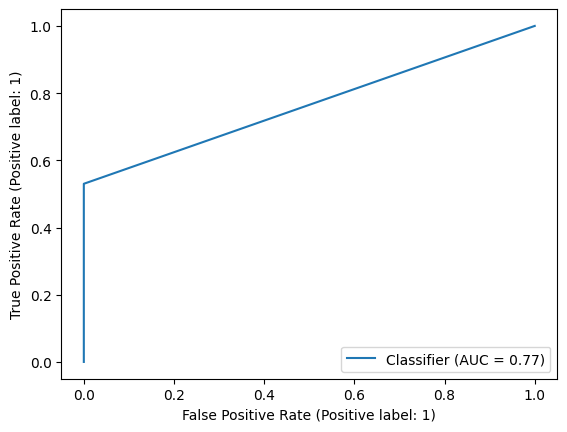

In [ ]:
estimates = classic_estimates_finite[:,2]
# estimates = y_pred_SVR_regression_chaos
plt.scatter(y_train, estimates, s=1)
plt.show()
plt.plot(system_training_data[SYSTEM]["sys_params"], y_train, lw=0.7)
plt.plot(system_training_data[SYSTEM]["sys_params"], estimates, lw=0.7)
plt.show()
conf_mat = confusion_matrix(y_train>0, estimates>0, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_train>0, estimates>0, normalize='all')
plt.show()
RocCurveDisplay.from_predictions(y_train>0, estimates>0)
plt.show()